In [1]:
!python ../setup.py build_ext --inplace

running build_ext
copying build/lib.macosx-10.9-x86_64-cpython-38/agent_timestep_plasticity.cpython-38-darwin.so -> 
running build_ext
copying build/lib.macosx-10.9-x86_64-cpython-38/agent_timestep_stop_signal.cpython-38-darwin.so -> 
/Users/cristina/Desktop/CBGTpy_sonoma/CBGTPy/notebooks/agent_timestep_stop_signal.cpython-38-darwin.so
/Users/cristina/Desktop/CBGTpy_sonoma/CBGTPy/notebooks/agent_timestep_plasticity.cpython-38-darwin.so


In [2]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import pickle
import seaborn as sns
import pathos.multiprocessing
import gc

#Importing scripts:

#Import relevant frames:
import common.cbgt as cbgt
import common.pipeline_creation as pl_creat

#Import plotting functions:
import common.plotting_functions as plt_func
import common.plotting_helper_functions as plt_help
import common.postprocessing_helpers as post_help


def saveresults_vars(variable, prefix):
    pickle.dump(variable, open(prefix, 'wb'))
    
def loadresults_vars(prefix):
    return pickle.load(open(prefix, "rb"))

data_dir = "../Results/Data_results/weights_analysis/GPeA_dSPN-iSPN/"
figure_dir = "../Results/Experimental_results"

In [3]:
solutions_dSPN = np.arange(0.02, 0.44, 0.05) 
solutions_iSPN =  np.arange(0.02, 0.64, 0.05)

print(solutions_dSPN)
print(solutions_iSPN)

[0.02 0.07 0.12 0.17 0.22 0.27 0.32 0.37 0.42]
[0.02 0.07 0.12 0.17 0.22 0.27 0.32 0.37 0.42 0.47 0.52 0.57 0.62]


# Plots

### Datatables

In [4]:
datatables = pd.DataFrame()

for i in np.arange(len(solutions_dSPN)):
    
    for k in np.arange(len(solutions_iSPN)):
    
        net = pickle.load(open(data_dir+'network_data_GPeA-dSPN-iSPN_iSPN+STN+GPeA_'+str(i)+'_'+str(k), 'rb'))

        for j in np.arange(len(net)):

            temp = net[j]['datatables']
            temp['GPeA-dSPN'] = solutions_dSPN[i]
            temp['GPeA-iSPN'] = solutions_iSPN[k]
            temp['num_stops'] = [1 if x == 'stop' else 0 for x in temp.decision]
            temp['thread'] = j
            #temp['p_stop'] = sum(temp['num_stops'].values/50)
            datatables = pd.concat([datatables, temp], ignore_index = False) #True

datatables['GPeA-dSPN'] = np.round(datatables['GPeA-dSPN'].values, 3)
datatables['GPeA-iSPN'] = np.round(datatables['GPeA-iSPN'].values, 3)
saveresults_vars(datatables, data_dir+'datatables_weights-analysis_GPeA-dSPN-iSPN')

In [5]:
datatables

,decision,stimulusstarttime,decisiontime,decisionduration,decisiondurationplusdelay,rewardtime,correctdecision,reward,GPeA-dSPN,GPeA-iSPN,num_stops,thread
0,left,0,286,286,587,587,left,1.0,0.02,0.02,0,0
1,left,1188,1486,298,599,1787,left,1.0,0.02,0.02,0,0
2,stop,2388,2689,301,602,2990,left,0.0,0.02,0.02,1,0
3,left,3591,3874,283,584,4175,left,1.0,0.02,0.02,0,0
4,left,4776,4849,73,374,5150,left,1.0,0.02,0.02,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
25,left,28774,28843,69,370,29144,left,1.0,0.42,0.62,0,9
26,left,29745,30042,297,598,30343,left,1.0,0.42,0.62,0,9
27,left,30944,31240,296,597,31541,left,1.0,0.42,0.62,0,9
28,left,32142,32441,299,600,32742,left,1.0,0.42,0.62,0,9


In [6]:
p_stop_average = pd.DataFrame(datatables.groupby(['GPeA-dSPN', 'GPeA-iSPN'])['num_stops'].mean()).reset_index()
p_stop_average = p_stop_average.rename({'num_stops': 'p_stop'}, axis=1)
saveresults_vars(p_stop_average, data_dir+'p_stop_average_weights-analysis')
p_stop_average

,GPeA-dSPN,GPeA-iSPN,p_stop
0,0.02,0.02,0.213333
1,0.02,0.07,0.103333
2,0.02,0.12,0.050000
3,0.02,0.17,0.046667
4,0.02,0.22,0.013333
...,...,...,...
112,0.42,0.42,0.443333
113,0.42,0.47,0.406667
114,0.42,0.52,0.306667
115,0.42,0.57,0.276667


In [7]:
p_stop_average = loadresults_vars(data_dir+'p_stop_average_weights-analysis')

In [8]:
p_stop_table = p_stop_average.pivot_table(index='GPeA-iSPN', columns='GPeA-dSPN', values='p_stop')
p_stop_table

GPeA-dSPN,0.02,0.07,0.12,0.17,0.22,0.27,0.32,0.37,0.42
GPeA-iSPN,,,,,,,,,
0.02,0.213333,0.310000,0.496667,0.636667,0.743333,0.763333,0.846667,0.900000,0.923333
0.07,0.103333,0.256667,0.360000,0.490000,0.636667,0.756667,0.766667,0.876667,0.893333
0.12,0.050000,0.170000,0.253333,0.373333,0.503333,0.633333,0.773333,0.803333,0.846667
0.17,0.046667,0.093333,0.173333,0.306667,0.426667,0.540000,0.660000,0.773333,0.790000
0.22,0.013333,0.083333,0.120000,0.233333,0.346667,0.406667,0.533333,0.666667,0.730000
0.27,0.003333,0.060000,0.060000,0.166667,0.260000,0.336667,0.503333,0.610000,0.683333
0.32,0.010000,0.020000,0.056667,0.116667,0.206667,0.266667,0.426667,0.500000,0.583333
0.37,0.003333,0.013333,0.023333,0.066667,0.090000,0.190000,0.316667,0.436667,0.520000
0.42,0.000000,0.000000,0.013333,0.046667,0.106667,0.190000,0.280000,0.360000,0.443333


In [9]:
p_stop_reverse = p_stop_table.iloc[::-1]
p_stop_reverse

GPeA-dSPN,0.02,0.07,0.12,0.17,0.22,0.27,0.32,0.37,0.42
GPeA-iSPN,,,,,,,,,
0.62,0.000000,0.000000,0.003333,0.006667,0.036667,0.070000,0.063333,0.156667,0.256667
0.57,0.000000,0.000000,0.006667,0.003333,0.020000,0.063333,0.090000,0.223333,0.276667
0.52,0.000000,0.000000,0.003333,0.016667,0.056667,0.106667,0.156667,0.216667,0.306667
0.47,0.003333,0.003333,0.003333,0.030000,0.086667,0.143333,0.193333,0.293333,0.406667
0.42,0.000000,0.000000,0.013333,0.046667,0.106667,0.190000,0.280000,0.360000,0.443333
0.37,0.003333,0.013333,0.023333,0.066667,0.090000,0.190000,0.316667,0.436667,0.520000
0.32,0.010000,0.020000,0.056667,0.116667,0.206667,0.266667,0.426667,0.500000,0.583333
0.27,0.003333,0.060000,0.060000,0.166667,0.260000,0.336667,0.503333,0.610000,0.683333
0.22,0.013333,0.083333,0.120000,0.233333,0.346667,0.406667,0.533333,0.666667,0.730000


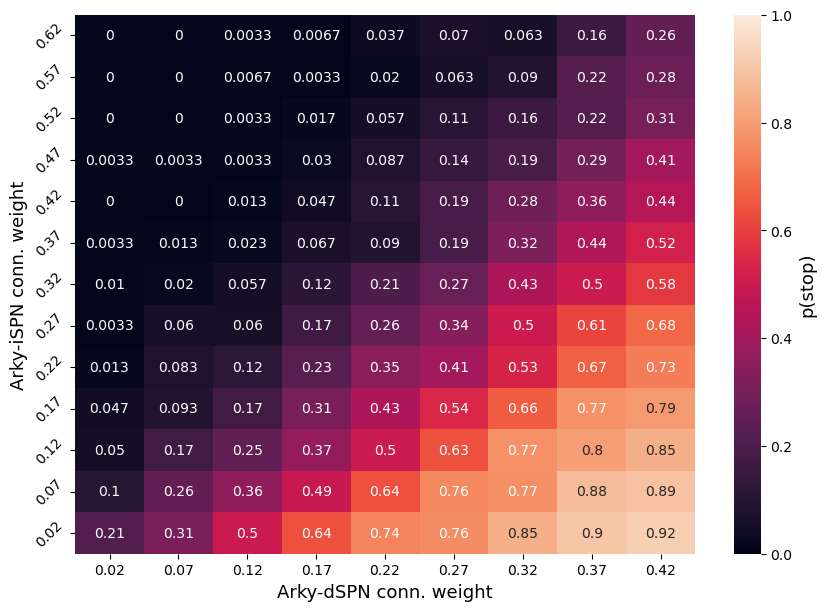

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(10, 7))
#sns.pointplot(data=datatables_D1, x='GPeA-D1', y='num_stops', errorbar="sd", ax = ax, color='brown')
sns.heatmap(p_stop_reverse, cbar_kws={'label': 'p(stop)'}, 
           vmin=0, vmax=1, annot=True)

#plt.title('p(stop) as a GPeA-dSPN and GPeA-iSPN conn. weights - 1 channel')
ax.tick_params(axis='y', labelrotation=45)
ax.set_xlabel('Arky-dSPN conn. weight', fontsize=13.)
ax.set_ylabel('Arky-iSPN conn. weight', fontsize=13.)
ax.figure.axes[-1].yaxis.label.set_size(13.)

plt.savefig(figure_dir+'p_stop-heatmap_weights-analysis_GPeA-dSPN-iSPN', dpi=300)

### Difference in terms of p(stop) between sims

In [ ]:
p_stop_table_diff = p_stop_table_10 - p_stop_table_6
p_stop_reverse_diff = p_stop_table_diff.iloc[::-1]
p_stop_reverse_diff

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(10, 6))
#sns.pointplot(data=datatables_D1, x='GPeA-D1', y='num_stops', errorbar="sd", ax = ax, color='brown')
sns.heatmap(p_stop_reverse_diff, cmap="coolwarm", cbar_kws={'label': 'p(stop)'}, 
           vmin=-1, vmax=1, annot=True)
plt.title('Difference - 6 vs 10 threads - 1 channel')

plt.savefig(figure_dir+'p_stop-heatmap_stop-params-analysis_threads-diff')

### Confidence Interval

In [ ]:
p_stop_average = pd.DataFrame(datatables.groupby(['GPeA-dSPN', 'GPeA-iSPN', 'thread'])['num_stops'].mean()).reset_index()
p_stop_average = p_stop_average.rename({'num_stops': 'p_stop'}, axis=1)
#saveresults_vars(p_stop_average, data_dir+'p_stop_average_iSPN+D2+GPeA')
p_stop_average

In [ ]:
import scipy.stats as st
from sklearn.metrics import r2_score, mean_squared_error

def st_interval(g):
    st_interval = st.t.interval(0.95, len(g) -1, loc=np.mean(g.p_stop), scale=st.sem(g.p_stop))
    return pd.Series( dict({'low': st_interval[0], 'high': st_interval[1]}))


p_stop_t = p_stop_average.groupby(['GPeA-dSPN', 'GPeA-iSPN']).apply(st_interval).reset_index()

In [ ]:
np.where(np.isnan(p_stop_t.low))

In [ ]:
p_stop_table_low = p_stop_t.pivot_table(index='GPeA-iSPN', columns='GPeA-dSPN', values='low')
p_stop_reverse_low = p_stop_table_low.iloc[::-1]
p_stop_reverse_low

In [ ]:
np.where(np.isnan(p_stop_t.high))

In [ ]:
p_stop_table_high = p_stop_t.pivot_table(index='GPeA-iSPN', columns='GPeA-dSPN', values='high')
p_stop_reverse_high = p_stop_table_high.iloc[::-1]
p_stop_reverse_high

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(10, 4.5)) #10, 7 - square
#sns.pointplot(data=datatables_D1, x='GPeA-D1', y='num_stops', errorbar="sd", ax = ax, color='brown')
sns.heatmap(p_stop_reverse_low, cmap='Greens_r', cbar_kws={'label': 'p(stop)'}, 
           vmin=0, vmax=1, annot=True)
plt.title('Lower bound - 95% Confidence interval')
ax.tick_params(axis='y', labelrotation=45)

ax.set_xlabel('GPeA-dSPN conn. weight')
ax.set_ylabel('GPeA-iSPN conn.weight')

plt.savefig(figure_dir+'p_stop-heatmap_weights-analysis_GPeA-dSPN-iSPN_t-low', dpi=200)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(10, 4.5))
#sns.pointplot(data=datatables_D1, x='GPeA-D1', y='num_stops', errorbar="sd", ax = ax, color='brown')
sns.heatmap(p_stop_reverse_high, cmap='Purples_r', cbar_kws={'label': 'p(stop)'}, 
           vmin=0, vmax=1, annot=True)
plt.title('Upper bound - 95% Confidence interval')
ax.tick_params(axis='y', labelrotation=45)

ax.set_xlabel('GPeA-dSPN conn. weight')
ax.set_ylabel('GPeA-iSPN conn.weight')

plt.savefig(figure_dir+'p_stop-heatmap_weights-analysis_GPeA-dSPN-iSPN_t-high', dpi=200)